# Project: Dog vs Cat Classification

In [1]:
from pathlib import Path
import os
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [4]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Cat, Shape: (375, 500, 3)')

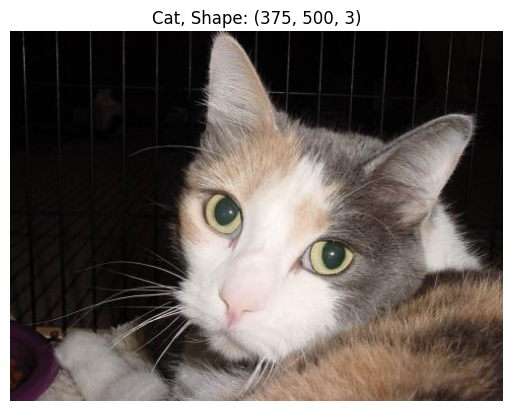

In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [7]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [8]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.0471, 0.0471, 0.0588,  ..., 0.0118, 0.0275, 0.0039],
         [0.0431, 0.0510, 0.0588,  ..., 0.0157, 0.0353, 0.0039],
         [0.0392, 0.0471, 0.0588,  ..., 0.0196, 0.0392, 0.0039],
         ...,
         [0.2078, 0.2745, 0.3686,  ..., 0.1725, 0.1294, 0.1412],
         [0.2000, 0.2510, 0.2902,  ..., 0.2118, 0.1765, 0.1412],
         [0.1922, 0.2078, 0.2471,  ..., 0.2471, 0.2118, 0.1843]],

        [[0.0314, 0.0314, 0.0431,  ..., 0.0118, 0.0275, 0.0039],
         [0.0275, 0.0353, 0.0431,  ..., 0.0157, 0.0353, 0.0039],
         [0.0275, 0.0353, 0.0471,  ..., 0.0196, 0.0392, 0.0039],
         ...,
         [0.1529, 0.2039, 0.2784,  ..., 0.0706, 0.0588, 0.0745],
         [0.1451, 0.1882, 0.2118,  ..., 0.0824, 0.0706, 0.0627],
         [0.1490, 0.1608, 0.1843,  ..., 0.0980, 0.0784, 0.0706]],

        [[0.0275, 0.0275, 0.0392,  ..., 0.0118, 0.0275, 0.0039],
         [0.0235, 0.0314, 0.0392,  ..., 0.0157, 0.0353, 0.0039],
         [0.0235, 0.0314, 0.0392,  ..., 0.0196, 0.0392, 0.

Text(0.5, 1.0, 'Cat, Shape: torch.Size([3, 64, 64])')

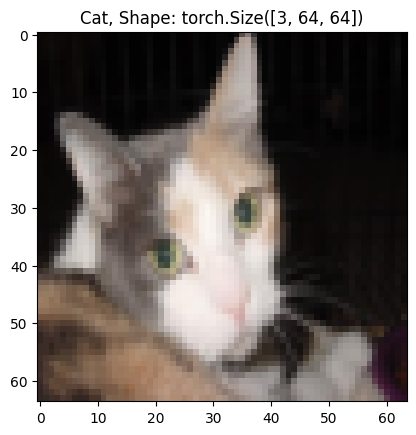

In [9]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [10]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1968
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 433
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [11]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [12]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [13]:
len(train_data), len(test_data)

(1968, 433)

# Turn loaded images into 'DataLoader'

In [14]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25bd58e2e50>,
 <torch.utils.data.dataloader.DataLoader at 0x25bd58e2700>)

In [15]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [16]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
           # nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [17]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): S

In [18]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [19]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[ 0.0287],
        [-0.0559],
        [-0.0756],
        [-0.2281],
        [-0.0321],
        [ 0.0953],
        [ 0.0669],
        [-0.2770],
        [ 0.0244],
        [-0.1356],
        [-0.0207],
        [-0.0500],
        [-0.0040],
        [ 0.0517],
        [-0.4060],
        [-0.0026],
        [-0.2139],
        [ 0.1342],
        [-0.0623],
        [ 0.0309],
        [-0.0971],
        [-0.0645],
        [-0.1326],
        [ 0.0814],
        [-0.1156],
        [-0.0979],
        [ 0.0247],
        [-0.0579],
        [ 0.0647],
        [-0.2253],
        [ 0.2130],
        [ 0.0482]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
from tqdm import tqdm
import time

In [21]:
epochs = 5

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

 20%|██        | 1/5 [00:06<00:24,  6.11s/it]

Epoch: 0 | Train Loss: 1.1242, Train Accuracy: 58.67 | Test Loss: 0.7012913056782314, Test Accuracy: 65.66439075630252


 40%|████      | 2/5 [00:11<00:16,  5.56s/it]

Epoch: 1 | Train Loss: 0.6475, Train Accuracy: 66.94 | Test Loss: 0.7429109141230583, Test Accuracy: 60.71428571428571


 60%|██████    | 3/5 [00:16<00:11,  5.56s/it]

Epoch: 2 | Train Loss: 0.6262, Train Accuracy: 68.80 | Test Loss: 0.6484467078532491, Test Accuracy: 69.22268907563026


 80%|████████  | 4/5 [00:22<00:05,  5.48s/it]

Epoch: 3 | Train Loss: 0.5528, Train Accuracy: 71.72 | Test Loss: 0.6228021127837045, Test Accuracy: 69.66911764705883


100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

Epoch: 4 | Train Loss: 0.5164, Train Accuracy: 75.60 | Test Loss: 0.5861124332462039, Test Accuracy: 71.73056722689076
Total time: 27.586931943893433


# Plot model_0 results

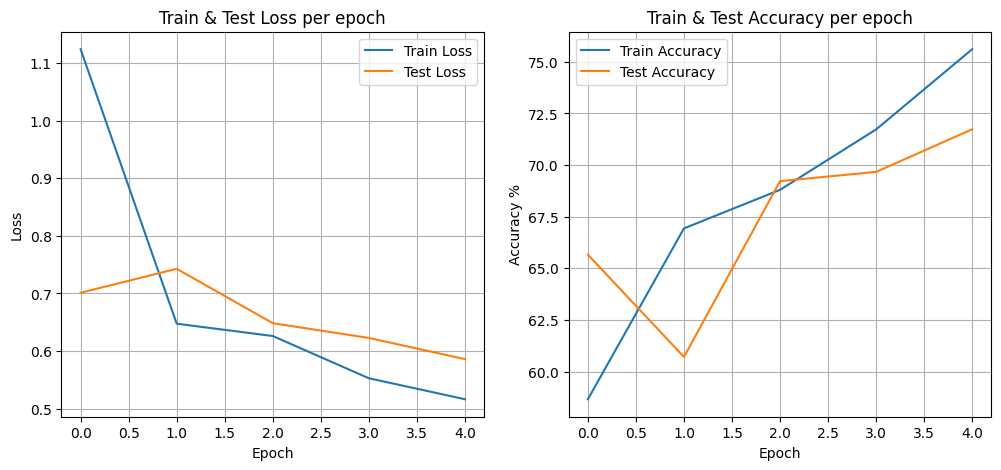

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [23]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

5 5
5 5


In [24]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [25]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [26]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [27]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 1968
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 433
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Norma

In [28]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x25b85d3c6d0>,
 <torch.utils.data.dataloader.DataLoader at 0x25b85d3c430>)

In [29]:
len(class_names)

2

In [30]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequen

In [31]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.00025
     maximize: False
     weight_decay: 0
 ))

In [32]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:07<06:19,  7.74s/it]

Epoch: 0 | Train Loss: 0.7566, Train Accuracy: 52.69 | Test Loss: 0.6880, Test Accuracy: 57.74


  4%|▍         | 2/50 [00:16<06:36,  8.26s/it]

Epoch: 1 | Train Loss: 0.6878, Train Accuracy: 55.54 | Test Loss: 0.6789, Test Accuracy: 52.66


  6%|▌         | 3/50 [00:24<06:25,  8.19s/it]

Epoch: 2 | Train Loss: 0.6842, Train Accuracy: 56.61 | Test Loss: 0.6707, Test Accuracy: 67.44


  8%|▊         | 4/50 [00:32<06:15,  8.16s/it]

Epoch: 3 | Train Loss: 0.6812, Train Accuracy: 59.96 | Test Loss: 0.6687, Test Accuracy: 64.90


 10%|█         | 5/50 [00:40<06:02,  8.05s/it]

Epoch: 4 | Train Loss: 0.6790, Train Accuracy: 59.45 | Test Loss: 0.6620, Test Accuracy: 59.12


 12%|█▏        | 6/50 [00:48<05:53,  8.05s/it]

Epoch: 5 | Train Loss: 0.6694, Train Accuracy: 60.82 | Test Loss: 0.6495, Test Accuracy: 60.97


 14%|█▍        | 7/50 [00:56<05:39,  7.89s/it]

Epoch: 6 | Train Loss: 0.6706, Train Accuracy: 60.98 | Test Loss: 0.6532, Test Accuracy: 63.05


 16%|█▌        | 8/50 [01:03<05:27,  7.80s/it]

Epoch: 7 | Train Loss: 0.6624, Train Accuracy: 62.65 | Test Loss: 0.6409, Test Accuracy: 64.43


 18%|█▊        | 9/50 [01:11<05:17,  7.74s/it]

Epoch: 8 | Train Loss: 0.6588, Train Accuracy: 63.92 | Test Loss: 0.6235, Test Accuracy: 70.67


 20%|██        | 10/50 [01:18<05:08,  7.70s/it]

Epoch: 9 | Train Loss: 0.6576, Train Accuracy: 61.48 | Test Loss: 0.6286, Test Accuracy: 63.97


 22%|██▏       | 11/50 [01:26<05:00,  7.71s/it]

Epoch: 10 | Train Loss: 0.6514, Train Accuracy: 64.08 | Test Loss: 0.6112, Test Accuracy: 71.82


 24%|██▍       | 12/50 [01:34<04:51,  7.68s/it]

Epoch: 11 | Train Loss: 0.6507, Train Accuracy: 64.84 | Test Loss: 0.6045, Test Accuracy: 71.13


 26%|██▌       | 13/50 [01:41<04:43,  7.67s/it]

Epoch: 12 | Train Loss: 0.6523, Train Accuracy: 62.70 | Test Loss: 0.6088, Test Accuracy: 69.28


 28%|██▊       | 14/50 [01:49<04:33,  7.61s/it]

Epoch: 13 | Train Loss: 0.6433, Train Accuracy: 65.40 | Test Loss: 0.5966, Test Accuracy: 69.75


 30%|███       | 15/50 [01:56<04:26,  7.62s/it]

Epoch: 14 | Train Loss: 0.6407, Train Accuracy: 66.16 | Test Loss: 0.6066, Test Accuracy: 71.36


 32%|███▏      | 16/50 [02:04<04:17,  7.59s/it]

Epoch: 15 | Train Loss: 0.6434, Train Accuracy: 65.75 | Test Loss: 0.6016, Test Accuracy: 72.06


 34%|███▍      | 17/50 [02:12<04:10,  7.59s/it]

Epoch: 16 | Train Loss: 0.6354, Train Accuracy: 66.11 | Test Loss: 0.5916, Test Accuracy: 75.29


 36%|███▌      | 18/50 [02:19<04:04,  7.64s/it]

Epoch: 17 | Train Loss: 0.6371, Train Accuracy: 65.14 | Test Loss: 0.5898, Test Accuracy: 71.59


 38%|███▊      | 19/50 [02:27<03:58,  7.71s/it]

Epoch: 18 | Train Loss: 0.6367, Train Accuracy: 66.36 | Test Loss: 0.5924, Test Accuracy: 69.05


 40%|████      | 20/50 [02:35<03:51,  7.73s/it]

Epoch: 19 | Train Loss: 0.6341, Train Accuracy: 64.84 | Test Loss: 0.5755, Test Accuracy: 74.60


 42%|████▏     | 21/50 [02:43<03:42,  7.69s/it]

Epoch: 20 | Train Loss: 0.6362, Train Accuracy: 65.85 | Test Loss: 0.5739, Test Accuracy: 73.67


 44%|████▍     | 22/50 [02:50<03:36,  7.73s/it]

Epoch: 21 | Train Loss: 0.6278, Train Accuracy: 66.16 | Test Loss: 0.5773, Test Accuracy: 72.98


 46%|████▌     | 23/50 [02:58<03:27,  7.69s/it]

Epoch: 22 | Train Loss: 0.6186, Train Accuracy: 67.68 | Test Loss: 0.5869, Test Accuracy: 72.06


 48%|████▊     | 24/50 [03:06<03:20,  7.73s/it]

Epoch: 23 | Train Loss: 0.6318, Train Accuracy: 64.94 | Test Loss: 0.5811, Test Accuracy: 72.06


 50%|█████     | 25/50 [03:14<03:13,  7.73s/it]

Epoch: 24 | Train Loss: 0.6147, Train Accuracy: 67.58 | Test Loss: 0.5626, Test Accuracy: 73.90


 52%|█████▏    | 26/50 [03:21<03:06,  7.78s/it]

Epoch: 25 | Train Loss: 0.6198, Train Accuracy: 68.04 | Test Loss: 0.5754, Test Accuracy: 71.36


 54%|█████▍    | 27/50 [03:31<03:10,  8.29s/it]

Epoch: 26 | Train Loss: 0.6213, Train Accuracy: 68.19 | Test Loss: 0.6268, Test Accuracy: 63.51


 56%|█████▌    | 28/50 [03:39<03:01,  8.25s/it]

Epoch: 27 | Train Loss: 0.6348, Train Accuracy: 64.02 | Test Loss: 0.5543, Test Accuracy: 74.36


 58%|█████▊    | 29/50 [03:48<02:59,  8.56s/it]

Epoch: 28 | Train Loss: 0.6127, Train Accuracy: 68.39 | Test Loss: 0.5697, Test Accuracy: 72.29


 60%|██████    | 30/50 [03:57<02:50,  8.52s/it]

Epoch: 29 | Train Loss: 0.6187, Train Accuracy: 67.89 | Test Loss: 0.5665, Test Accuracy: 70.67


 62%|██████▏   | 31/50 [04:05<02:40,  8.47s/it]

Epoch: 30 | Train Loss: 0.5995, Train Accuracy: 68.60 | Test Loss: 0.5544, Test Accuracy: 72.98


 64%|██████▍   | 32/50 [04:13<02:31,  8.41s/it]

Epoch: 31 | Train Loss: 0.6044, Train Accuracy: 69.92 | Test Loss: 0.5484, Test Accuracy: 74.36


 66%|██████▌   | 33/50 [04:22<02:23,  8.47s/it]

Epoch: 32 | Train Loss: 0.6010, Train Accuracy: 69.82 | Test Loss: 0.5526, Test Accuracy: 74.36


 68%|██████▊   | 34/50 [04:31<02:15,  8.49s/it]

Epoch: 33 | Train Loss: 0.6084, Train Accuracy: 68.85 | Test Loss: 0.5471, Test Accuracy: 76.44


 70%|███████   | 35/50 [04:39<02:09,  8.61s/it]

Epoch: 34 | Train Loss: 0.5935, Train Accuracy: 69.72 | Test Loss: 0.5551, Test Accuracy: 72.75


 72%|███████▏  | 36/50 [04:48<02:00,  8.62s/it]

Epoch: 35 | Train Loss: 0.5953, Train Accuracy: 70.48 | Test Loss: 0.5460, Test Accuracy: 73.44


 74%|███████▍  | 37/50 [04:56<01:51,  8.56s/it]

Epoch: 36 | Train Loss: 0.5966, Train Accuracy: 70.48 | Test Loss: 0.5480, Test Accuracy: 76.21


 76%|███████▌  | 38/50 [05:05<01:43,  8.63s/it]

Epoch: 37 | Train Loss: 0.6023, Train Accuracy: 69.66 | Test Loss: 0.5504, Test Accuracy: 75.06


 78%|███████▊  | 39/50 [05:14<01:34,  8.62s/it]

Epoch: 38 | Train Loss: 0.5887, Train Accuracy: 70.93 | Test Loss: 0.5405, Test Accuracy: 75.29


 80%|████████  | 40/50 [05:23<01:26,  8.63s/it]

Epoch: 39 | Train Loss: 0.5939, Train Accuracy: 69.92 | Test Loss: 0.5358, Test Accuracy: 74.13


 82%|████████▏ | 41/50 [05:31<01:16,  8.55s/it]

Epoch: 40 | Train Loss: 0.5879, Train Accuracy: 70.12 | Test Loss: 0.5333, Test Accuracy: 74.13


 84%|████████▍ | 42/50 [05:40<01:08,  8.62s/it]

Epoch: 41 | Train Loss: 0.5864, Train Accuracy: 70.12 | Test Loss: 0.5538, Test Accuracy: 74.60


 86%|████████▌ | 43/50 [05:47<00:58,  8.38s/it]

Epoch: 42 | Train Loss: 0.5965, Train Accuracy: 69.05 | Test Loss: 0.5308, Test Accuracy: 77.83


 88%|████████▊ | 44/50 [05:56<00:50,  8.41s/it]

Epoch: 43 | Train Loss: 0.5846, Train Accuracy: 71.04 | Test Loss: 0.5376, Test Accuracy: 74.60


 90%|█████████ | 45/50 [06:05<00:42,  8.54s/it]

Epoch: 44 | Train Loss: 0.5805, Train Accuracy: 70.78 | Test Loss: 0.5388, Test Accuracy: 74.60


 92%|█████████▏| 46/50 [06:13<00:34,  8.55s/it]

Epoch: 45 | Train Loss: 0.5746, Train Accuracy: 71.34 | Test Loss: 0.5400, Test Accuracy: 74.83


 94%|█████████▍| 47/50 [06:22<00:25,  8.55s/it]

Epoch: 46 | Train Loss: 0.5754, Train Accuracy: 72.36 | Test Loss: 0.5265, Test Accuracy: 77.60


 96%|█████████▌| 48/50 [06:31<00:17,  8.57s/it]

Epoch: 47 | Train Loss: 0.5729, Train Accuracy: 72.71 | Test Loss: 0.5185, Test Accuracy: 78.06


 98%|█████████▊| 49/50 [06:40<00:08,  8.73s/it]

Epoch: 48 | Train Loss: 0.5804, Train Accuracy: 71.65 | Test Loss: 0.5343, Test Accuracy: 75.75


100%|██████████| 50/50 [06:48<00:00,  8.18s/it]

Epoch: 49 | Train Loss: 0.5716, Train Accuracy: 72.61 | Test Loss: 0.5276, Test Accuracy: 78.29
Total time: 408.7718982696533


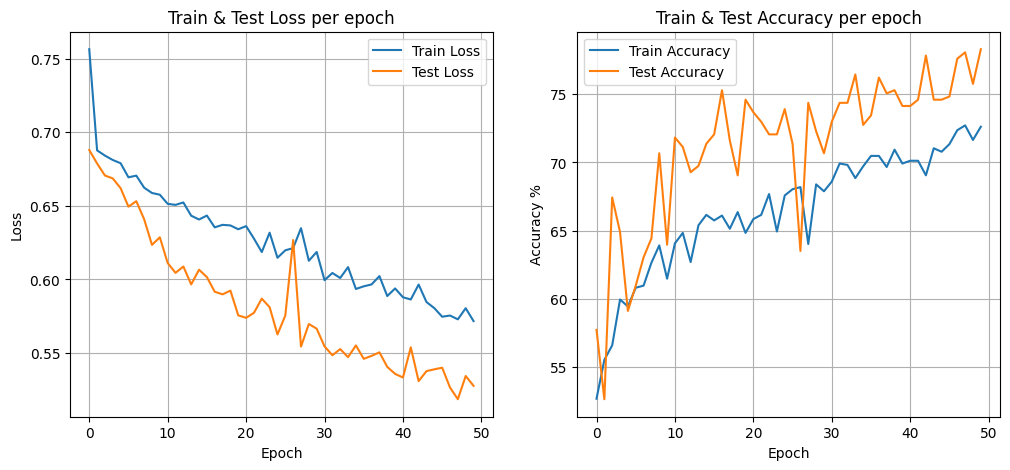

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [34]:
from torch.utils.data import Subset

In [35]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)